<a href="https://colab.research.google.com/github/mirpouya/Human-Emotion-Detection-with-various-CNN-models/blob/main/Human_Emotion_Detection_with_different_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import cv2

from tensorflow.keras.layers import (Resizing, Rescaling, InputLayer, Conv2D, BatchNormalization,
                                     MaxPool2D, Dropout, Flatten, Dense, RandomRotation, RandomFlip, RandomContrast, Activation,
                                     Add, GlobalAveragePooling2D, MaxPooling2D)
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import TopKCategoricalAccuracy, CategoricalAccuracy
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
from tensorflow.keras.callbacks import  ModelCheckpoint

In [2]:

CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

<h1> Data Management </h1>

<h2> Downloading data from kaggle </h2>

In [3]:
pip install -q kaggle

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [5]:
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

 99% 306M/309M [00:08<00:00, 40.8MB/s]
100% 309M/309M [00:08<00:00, 39.1MB/s]


unzipping dataset

In [ ]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset"

train and test directories

In [8]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"

"""
train_directory_1 = "/content/dataset/EmotionsDataset_Splitted/data/train"
val_directory_1 = "/content/dataset/EmotionsDataset_Splitted/data/test"
"""

'\ntrain_directory_1 = "/content/dataset/EmotionsDataset_Splitted/data/train"\nval_directory_1 = "/content/dataset/EmotionsDataset_Splitted/data/test"\n'

<h2> Data Loading </h2>

In [9]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels = "inferred",
    label_mode = "categorical",
    class_names = CONFIGURATION["CLASS_NAMES"],
    color_mode = "rgb",
    batch_size = CONFIGURATION["BATCH_SIZE"],
    image_size = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle = True,
    seed = 99
)

Found 6799 files belonging to 3 classes.


In [10]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels = "inferred",
    label_mode = "categorical",
    class_names = CONFIGURATION["CLASS_NAMES"],
    color_mode = "rgb",
    batch_size = 1,
    image_size = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle = True,
    seed = 99
)

Found 2278 files belonging to 3 classes.


In [11]:
for im in train_dataset.take(1):
  print(im)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[115.       , 115.       , 115.       ],
         [110.9375   , 110.9375   , 110.9375   ],
         [111.375    , 111.375    , 111.375    ],
         ...,
         [ 40.3125   ,  40.3125   ,  40.3125   ],
         [ 41.1875   ,  41.1875   ,  41.1875   ],
         [ 42.       ,  42.       ,  42.       ]],

        [[115.       , 115.       , 115.       ],
         [112.25781  , 112.25781  , 112.25781  ],
         [110.765625 , 110.765625 , 110.765625 ],
         ...,
         [ 41.683594 ,  41.683594 ,  41.683594 ],
         [ 41.847656 ,  41.847656 ,  41.847656 ],
         [ 42.       ,  42.       ,  42.       ]],

        [[115.6875   , 115.6875   , 115.6875   ],
         [113.80859  , 113.80859  , 113.80859  ],
         [110.58203  , 110.58203  , 110.58203  ],
         ...,
         [ 41.570312 ,  41.570312 ,  41.570312 ],
         [ 40.496094 ,  40.496094 ,  40.496094 ],
         [ 39.9375   ,  39.9375   ,  39.9375

train_dataset.take(1), takes <b>one batch</b> from train set

<h2> Dataset Visualization </h2>

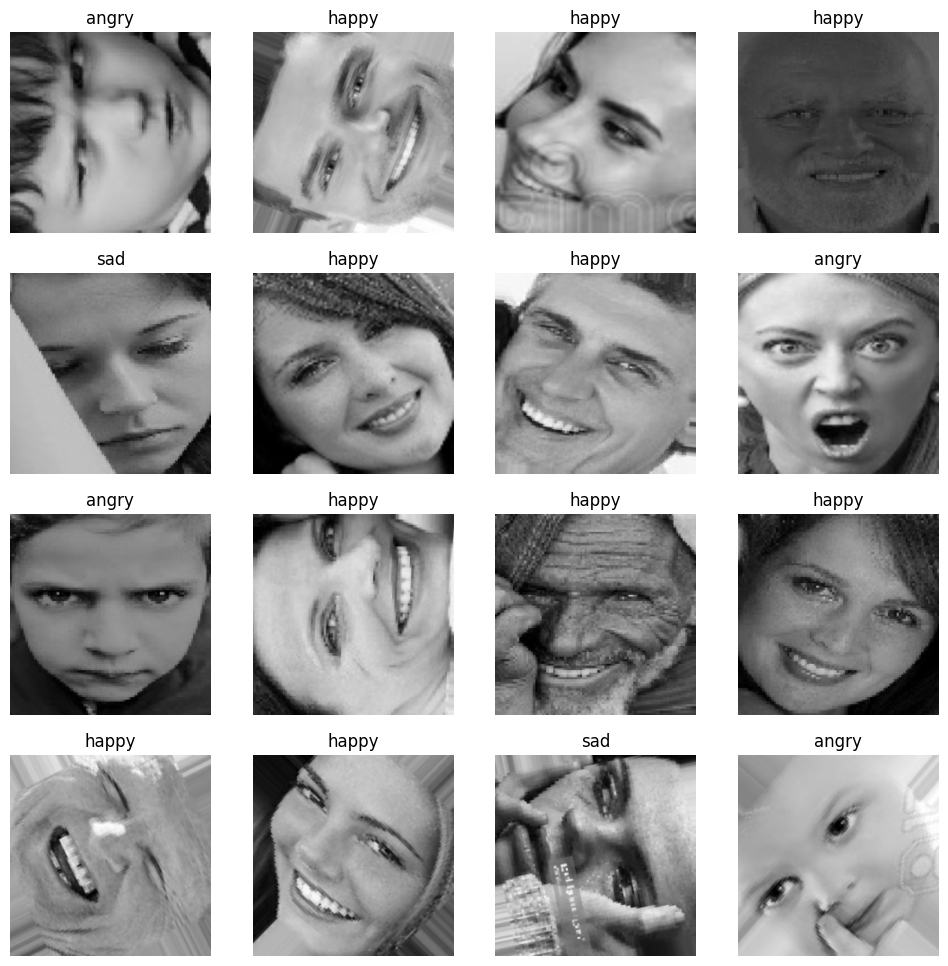

In [12]:
plt.figure(figsize=(12, 12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis=0).numpy()])
    plt.axis("off")

<h1> Dataset preparation </h1>

In [13]:
training_dataset = (
    train_dataset.prefetch(tf.data.AUTOTUNE)
)

In [14]:
validation_dataset = (
    val_dataset.prefetch(tf.data.AUTOTUNE)
)

In [13]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    Rescaling(1/255.)
])

In [16]:
y_true = [[0, 1, 0], [0, 0, 1]]
y_pred = [[0.05, 0.95, 0], [0.1, 1.35, 0.55]]
loss = CategoricalCrossentropy()
loss(y_true, y_pred).numpy()

0.6711387

<h1> Model </h1>

In [17]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

<h1> Training </h1>

<h3> define loss function </h3>

In [18]:
loss_function = CategoricalCrossentropy()
# loss_function = SparseCategoricalCrossentropy()

<h3> define metrics </h3>

In [19]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name="top_k_accuracy")]

<h3> compile the model </h3>

In [20]:
lenet_model.compile(
    optimizer = Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics
)

<h3> Training process </h3>

In [21]:
history = lenet_model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose = 1,
)

Epoch 1/20
213/213 [==============================] - 19s 52ms/step - loss: 0.8956 - accuracy: 0.6046 - top_k_accuracy: 0.8482 - val_loss: 1.1635 - val_accuracy: 0.5347 - val_top_k_accuracy: 0.7739
Epoch 2/20
213/213 [==============================] - 10s 48ms/step - loss: 0.4961 - accuracy: 0.8050 - top_k_accuracy: 0.9469 - val_loss: 0.8738 - val_accuracy: 0.6536 - val_top_k_accuracy: 0.8613
Epoch 3/20
213/213 [==============================] - 10s 48ms/step - loss: 0.2915 - accuracy: 0.8979 - top_k_accuracy: 0.9819 - val_loss: 0.9020 - val_accuracy: 0.6826 - val_top_k_accuracy: 0.8775
Epoch 4/20
213/213 [==============================] - 10s 48ms/step - loss: 0.2369 - accuracy: 0.9185 - top_k_accuracy: 0.9856 - val_loss: 1.0045 - val_accuracy: 0.6356 - val_top_k_accuracy: 0.8648
Epoch 5/20
213/213 [==============================] - 10s 48ms/step - loss: 0.1511 - accuracy: 0.9478 - top_k_accuracy: 0.9932 - val_loss: 0.9769 - val_accuracy: 0.7072 - val_top_k_accuracy: 0.8911
Epoch 6/20

In [22]:
type(history)

keras.src.callbacks.History

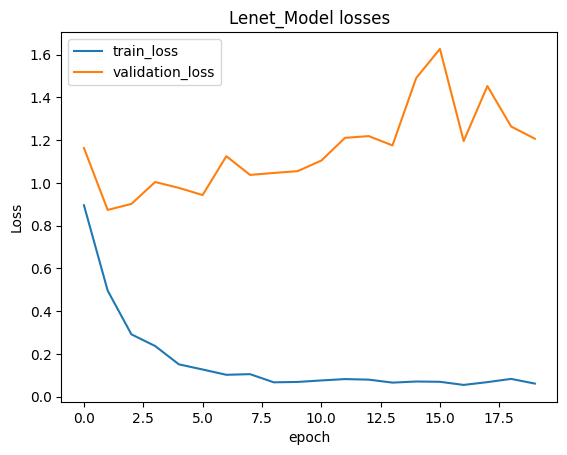

In [23]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Lenet_Model losses")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(["train_loss", "validation_loss"])
plt.show()

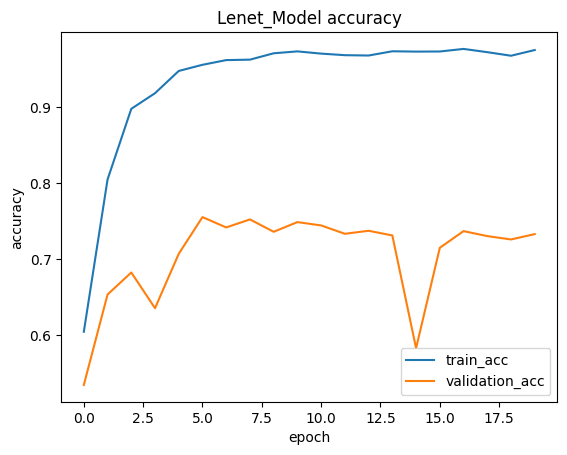

In [24]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Lenet_Model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train_acc", "validation_acc"])
plt.show()

<h1> Evaluation </h1>

In [25]:
lenet_model.evaluate(validation_dataset)

2278/2278 [==============================] - 7s 3ms/step - loss: 1.2071 - accuracy: 0.7331 - top_k_accuracy: 0.9047


[1.2070887088775635, 0.7330992221832275, 0.9047409892082214]

<h1> Testing </h1>

In [26]:
test_random_sample = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/111073.jpg")
im = tf.constant(test_random_sample, dtype=tf.float32)
print(im.shape)

(90, 90, 3)


In [27]:
# to conform with model input shape
im = tf.expand_dims(im, axis=0)
im.shape

TensorShape([1, 90, 90, 3])

In [28]:
lenet_model(im)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[2.2655659e-05, 9.9996936e-01, 8.0061909e-06]], dtype=float32)>

In [29]:
CONFIGURATION["CLASS_NAMES"][np.squeeze(tf.argmax(lenet_model(im), axis=-1).numpy())]

'happy'

<h1> Confusion Matrix </h1>

In [30]:
predicted = []
labels = []

for im, label in validation_dataset:
  predicted.append(lenet_model(im))
  labels.append(label.numpy())

In [31]:
labels[1]

array([[0., 0., 1.]], dtype=float32)

In [32]:
predicted[1]

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.00209681, 0.48609248, 0.5118107 ]], dtype=float32)>

In [33]:
# not picking the last batch, many times the len of last batch is less than the fixed size.
# if our dataset has 98 elements, we will have 3 batches of 32 images and 2 images in the last section
# so we do not pick the last batch to avoid an error in the code
# my batch size here is 1, so there is no problem in this code

print(np.argmax(labels[:-1], axis=-1))

[[1]
 [2]
 [1]
 ...
 [2]
 [2]
 [2]]


In [34]:
# let's pick the first two batches
print(np.argmax(labels[:], axis=-1).flatten())

[1 2 1 ... 2 2 0]


In [35]:
len(np.argmax(labels[:], axis=-1).flatten())

2278

In [36]:
print(np.argmax(predicted[:], axis=-1).flatten())

[1 2 1 ... 2 2 1]


In [37]:
len(np.argmax(predicted[:], axis=-1).flatten())

2278

In [38]:
preds = np.argmax(predicted[:], axis=-1).flatten()
true_classes = np.argmax(labels[:], axis=-1).flatten()

[[290 139  86]
 [ 24 876 106]
 [ 58 195 504]]


Text(0.5, 58.7222222222222, 'Predicted')

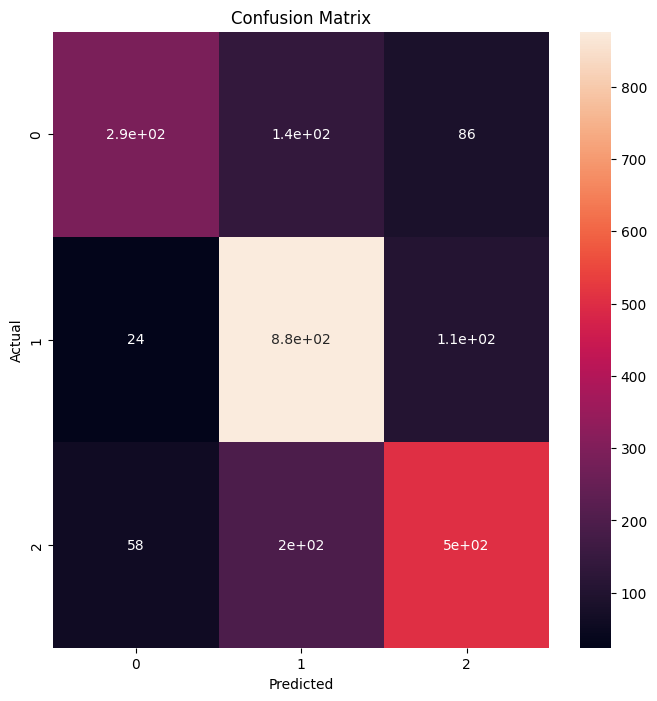

In [39]:
cm = confusion_matrix(y_true=true_classes, y_pred=preds)

print(cm)
plt.figure(figsize=(8, 8))

sns.heatmap(cm, annot=True)
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")

<h1> Data Augmentation </h1>

In [40]:
# make data augmentation through keras layers
augment_layers = tf.keras.Sequential([
    RandomRotation(factor=(0.25, 0.2501)),
    RandomFlip(mode="horizontal"),
    RandomContrast(factor=0.1)
])

In [41]:
# augmentation function

def augment_func(image, label):
  return augment_layers(resize_rescale_layers(image), training=True), label

<h3> integrating data augmentation only in training data </h3>

In [42]:
training_dataset = (
    train_dataset
    .map(augment_func, num_parallel_calls = tf.data.AUTOTUNE).
    prefetch(tf.data.AUTOTUNE)
)

<h3> Train the model with data augmentation </h3>

In [43]:
lenet_model.compile(
    optimizer = Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics
)

In [44]:
history = lenet_model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose = 1
)

Epoch 1/20
213/213 [==============================] - 16s 61ms/step - loss: 1.2876 - accuracy: 0.5299 - top_k_accuracy: 0.8092 - val_loss: 72.9280 - val_accuracy: 0.3406 - val_top_k_accuracy: 0.9293
Epoch 2/20
213/213 [==============================] - 13s 61ms/step - loss: 0.9545 - accuracy: 0.5557 - top_k_accuracy: 0.8307 - val_loss: 137.3884 - val_accuracy: 0.2761 - val_top_k_accuracy: 0.7989
Epoch 3/20
213/213 [==============================] - 13s 61ms/step - loss: 0.8318 - accuracy: 0.6226 - top_k_accuracy: 0.8726 - val_loss: 142.0794 - val_accuracy: 0.2950 - val_top_k_accuracy: 0.6874
Epoch 4/20
213/213 [==============================] - 13s 61ms/step - loss: 0.7203 - accuracy: 0.6888 - top_k_accuracy: 0.9003 - val_loss: 347.4443 - val_accuracy: 0.2322 - val_top_k_accuracy: 0.9754
Epoch 5/20
213/213 [==============================] - 13s 61ms/step - loss: 0.6594 - accuracy: 0.7228 - top_k_accuracy: 0.9176 - val_loss: 370.0776 - val_accuracy: 0.2673 - val_top_k_accuracy: 0.7028
E

<h3> Visualizing the result </h3>

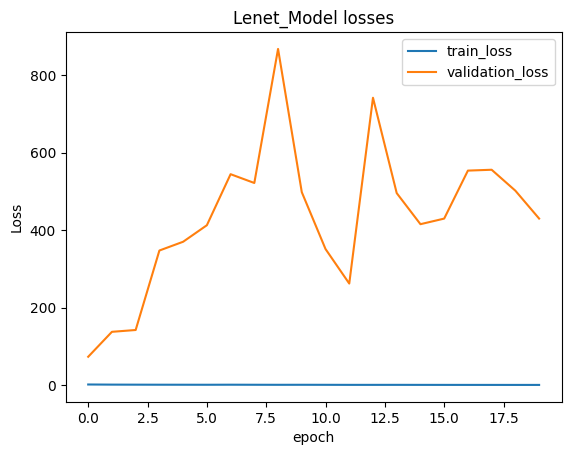

In [45]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Lenet_Model losses")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(["train_loss", "validation_loss"])
plt.show()

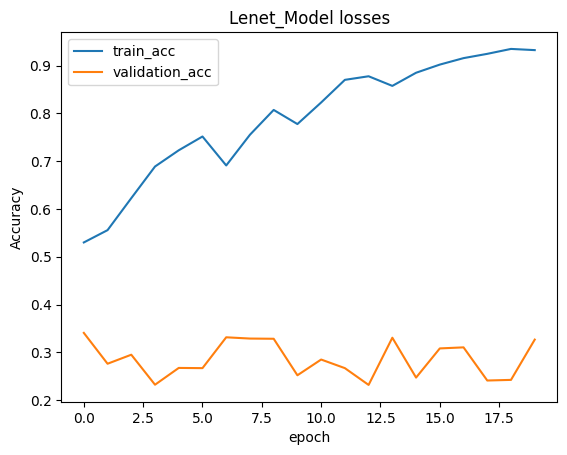

In [46]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Lenet_Model losses")
plt.ylabel("Accuracy")
plt.xlabel("epoch")
plt.legend(["train_acc", "validation_acc"])
plt.show()

<h3> Why validation loss is so low? </h3>

<h4> After all augmentation is expected to enhance model's performance </h4>

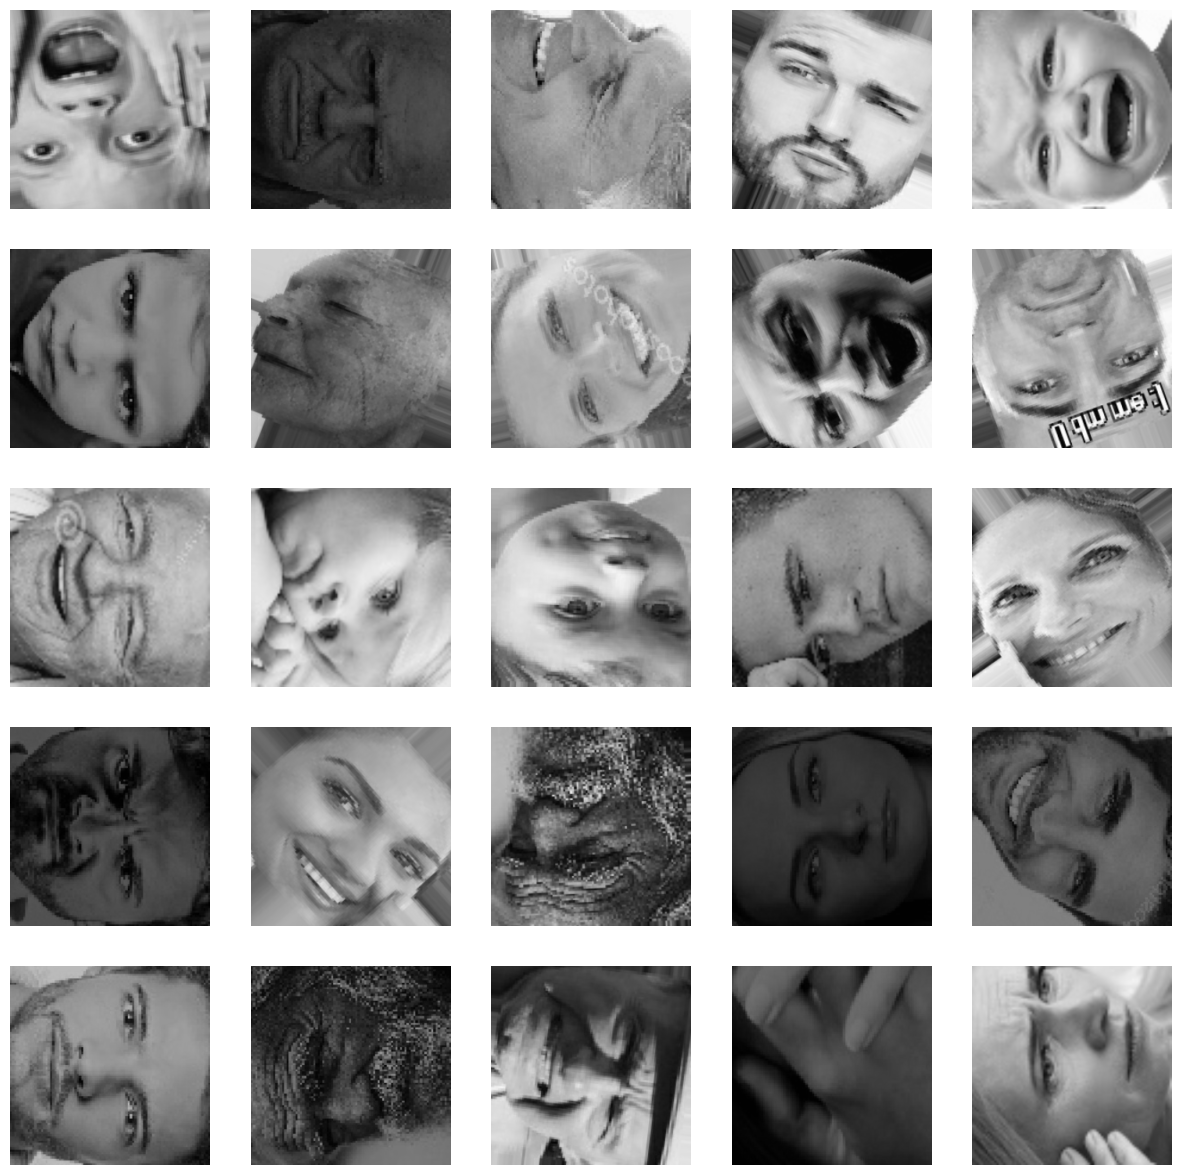

In [47]:
# to understand the reason behind this drop, let's visualiza the result of our augmentation

plt.figure(figsize=(15, 15))

for image, label in training_dataset.take(1):
  for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(image[i])
    plt.axis("off")

<h4> As you can see, the data augmentation alter some pictures to nonsensical images of faces, the noise and effect added to them make them unrealistic and out of natural shape, so the model will learn patterns not existing in our validation set </h4>

<h4> limiting our rotation between -0.025 rad to 0.025 rad which is -9 to 9 degrees </h4>


In [10]:
augmentation_layers = tf.keras.Sequential([
    RandomRotation(factor=(-0.025, 0.025)),
    RandomFlip(mode="horizontal"),
    RandomContrast(factor=0.1)
])

In [11]:
def augment_func(image, label):
  return augmentation_layers(resize_rescale_layers(image), training=True), label

<h2> Cutmix augmentation </h2>

In [50]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [51]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

In [52]:
train_dataset_1 = train_dataset.map(augment_func, num_parallel_calls = tf.data.AUTOTUNE)
train_dataset_2 = train_dataset.map(augment_func, num_parallel_calls = tf.data.AUTOTUNE)

mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [53]:
training_dataset = (
   mixed_dataset
   .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
   .prefetch(tf.data.AUTOTUNE)
)

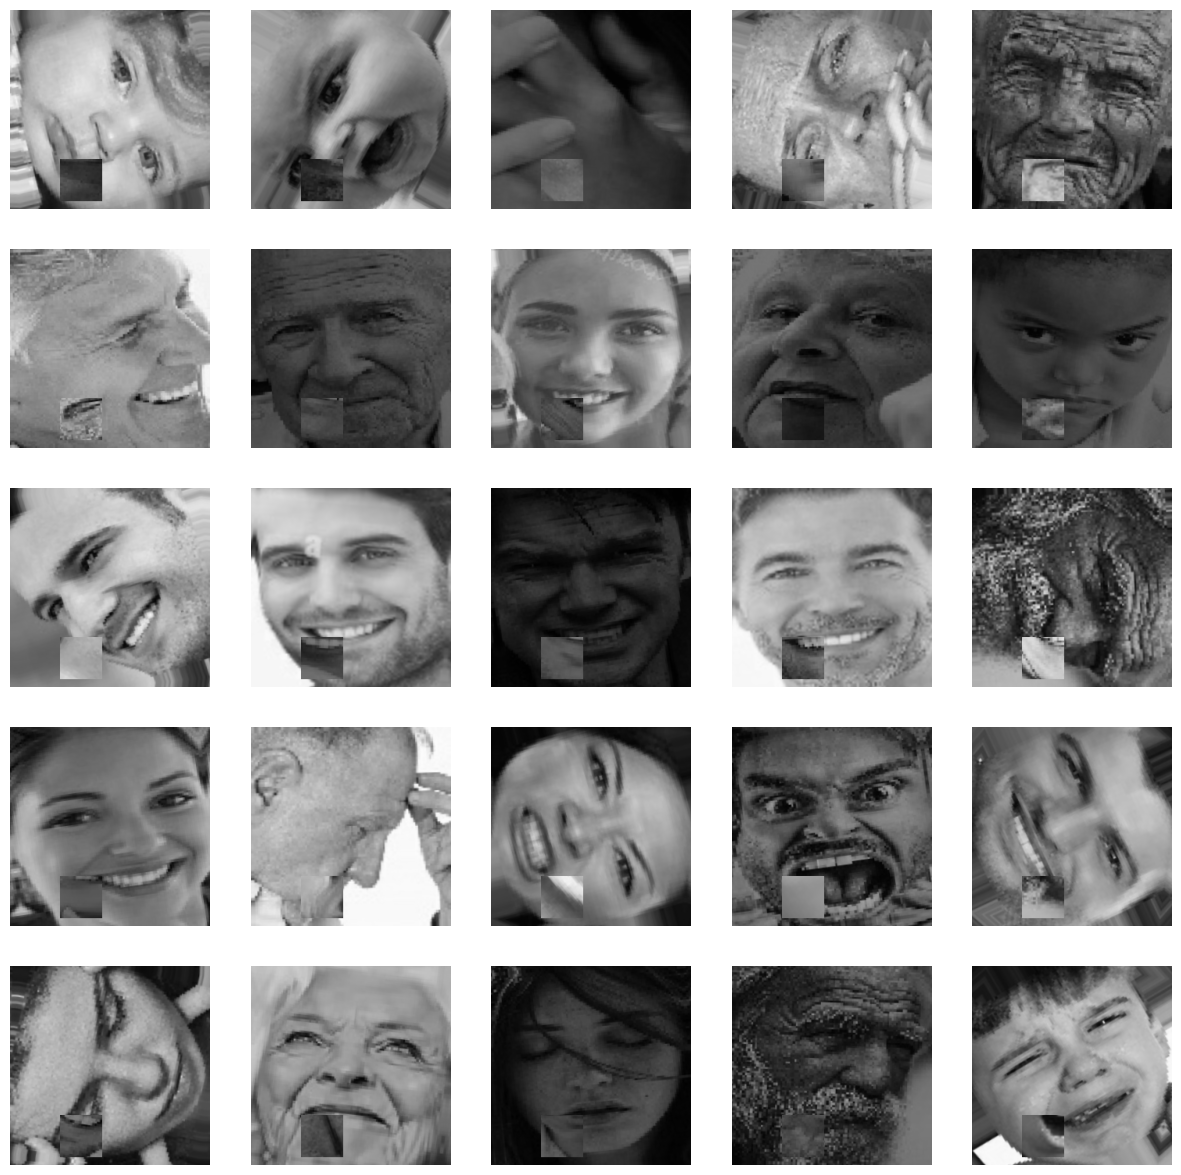

In [68]:
plt.figure(figsize=(15, 15))

for image, label in training_dataset.take(1):
  for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(image[i])
    plt.axis("off")

In [56]:
lenet_model.compile(
    optimizer = Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
    loss = loss_function,
    metrics = metrics
)

In [57]:
history = lenet_model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose = 1
)

Epoch 1/20
213/213 [==============================] - 23s 91ms/step - loss: 0.9348 - accuracy: 0.5722 - top_k_accuracy: 0.8397 - val_loss: 272.6254 - val_accuracy: 0.2331 - val_top_k_accuracy: 0.8411
Epoch 2/20
213/213 [==============================] - 21s 94ms/step - loss: 0.8671 - accuracy: 0.6402 - top_k_accuracy: 0.8748 - val_loss: 505.6491 - val_accuracy: 0.2261 - val_top_k_accuracy: 0.9974
Epoch 3/20
213/213 [==============================] - 21s 95ms/step - loss: 0.8416 - accuracy: 0.6563 - top_k_accuracy: 0.8831 - val_loss: 274.6342 - val_accuracy: 0.2300 - val_top_k_accuracy: 0.9535
Epoch 4/20
213/213 [==============================] - 21s 95ms/step - loss: 0.8308 - accuracy: 0.6719 - top_k_accuracy: 0.8895 - val_loss: 420.2375 - val_accuracy: 0.2537 - val_top_k_accuracy: 0.8310
Epoch 5/20
213/213 [==============================] - 21s 95ms/step - loss: 0.8055 - accuracy: 0.6833 - top_k_accuracy: 0.8969 - val_loss: 398.9533 - val_accuracy: 0.2735 - val_top_k_accuracy: 0.8595


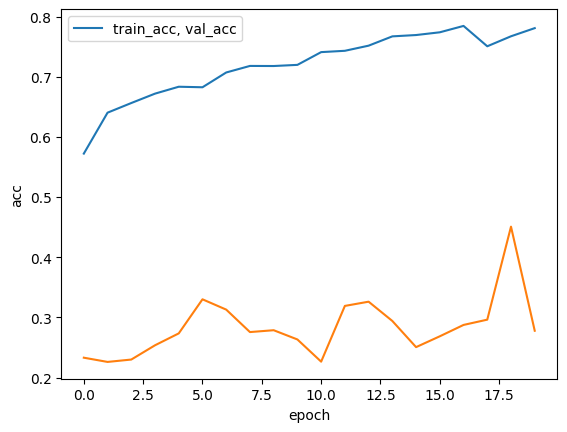

In [60]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel("acc")
plt.xlabel("epoch")
plt.legend(["train_acc, val_acc"])
plt.show()

Regarding our augmented dataset, no wonder our validation accuracy is so low, data augmentation must make sense and leads the model to more robustness for the changes that might occure in the test set, which may not be present in the train set, therefore, the type of data augmentation that helps the model to see unseen samples helps the model to be perform better on test set.

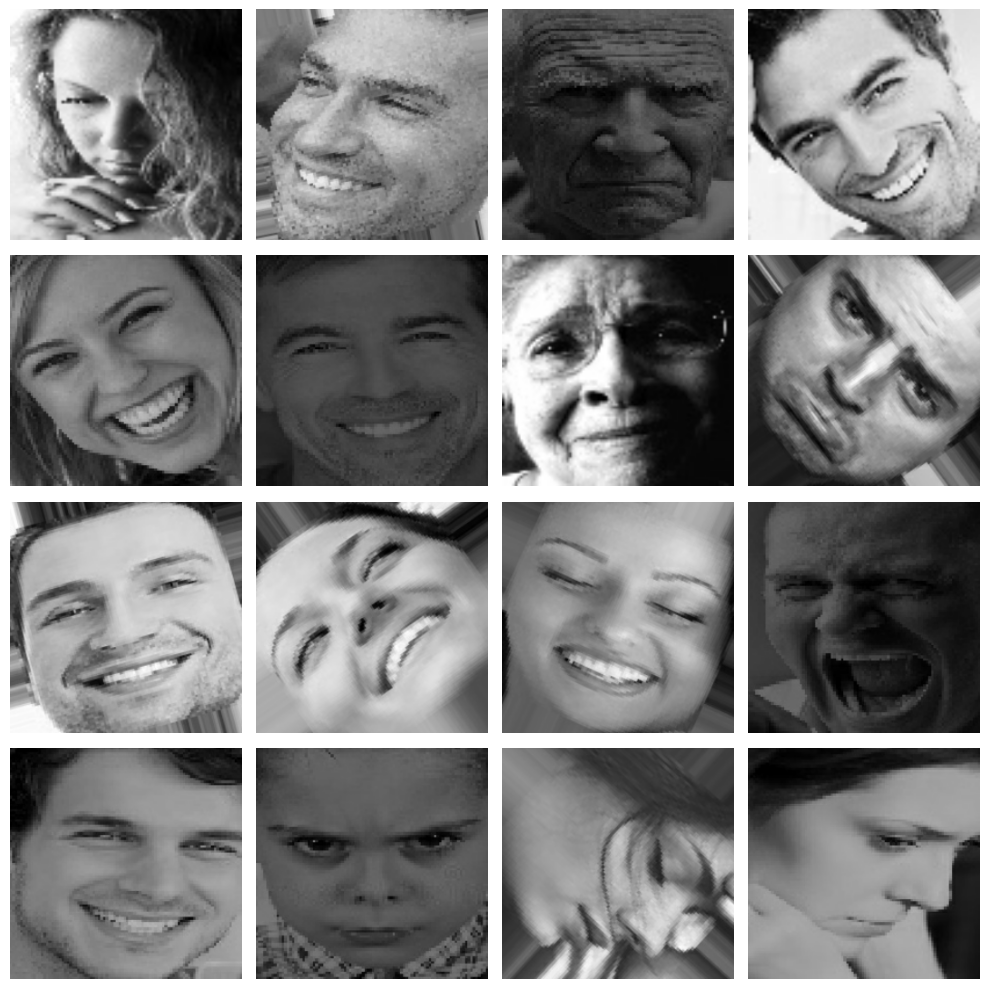

In [79]:
num_images_to_visualize = 16
plt.figure(figsize=(10, 10))  # Adjust the figure size if needed
for i, (images, labels) in enumerate(validation_dataset.take(num_images_to_visualize)):
  # Each "images" batch contains one image, so we select the first image
  image = images[0]

  # Convert the image tensor to numpy array
  image = image.numpy()

  # Add the subplot
  plt.subplot(4, 4, i + 1)  # Subplot indices start from 1
  plt.imshow(image.astype('uint8'))  # Convert to uint8 for proper visualization
  plt.axis('off')  # Turn off axis

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

<h1> Resnet Model </h1>

<h3> Data Preparation </h3>

In [9]:
# train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
# val_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"

train_data = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels="inferred",
    label_mode = "categorical",
    class_names = CONFIGURATION["CLASS_NAMES"],
    color_mode = "rgb",
    batch_size = CONFIGURATION['BATCH_SIZE'],
    image_size = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle = True,
    seed = 99
)



validation_data = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels = "inferred",
    label_mode = "categorical",
    class_names = CONFIGURATION["CLASS_NAMES"],
    color_mode = "rgb",
    batch_size = 1,
    image_size = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle = True,
    seed = 99
)

Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.


<h3> Making dataset </h3>

In [53]:
# training_dataset = (
#     train_dataset
#     .map(augment_func, num_parallel_calls = tf.data.AUTOTUNE).
#     prefetch(tf.data.AUTOTUNE)
# )

training_dataset = (
    train_data.
    prefetch(tf.data.AUTOTUNE)
)

validation_dataset = (
    validation_data.prefetch(tf.data.AUTOTUNE)
)

<h3> <b> building the model </b> </h3>

<h3> Custome Conv2d </h3>


In [54]:
class CustomConv2d(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = "valid"):
    super(CustomConv2d, self).__init__()

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = "relu",
        strides = n_strides,
        padding = padding
    )

    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x)

    return x

<h3> Residual Block </h3>

In [55]:
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__()

    self.dotted = (n_strides != 1)

    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

  def call(self, input, training):

    x = self.custom_conv_1(input, training)
    x = self.custom_conv_2(x, training)

    if self.dotted:
      x_add = self.custom_conv_3(input, training)
      x_add = Add()([x, x_add])
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)

<h3> main body of resnet </h3>

In [56]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)

    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x, training)

    return x

In [57]:
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)

    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

  def call(self, input, training):

    x = self.custom_conv_1(input, training)
    x = self.custom_conv_2(x, training)

    if self.dotted:
      x_add = self.custom_conv_3(input, training)
      x_add = Add()([x, x_add])
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)

In [58]:
class ResNet34(Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')

    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)

    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')

  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training)
    x = self.conv_2_2(x, training)
    x = self.conv_2_3(x, training)

    x = self.conv_3_1(x, training)
    x = self.conv_3_2(x, training)
    x = self.conv_3_3(x, training)
    x = self.conv_3_4(x, training)

    x = self.conv_4_1(x, training)
    x = self.conv_4_2(x, training)
    x = self.conv_4_3(x, training)
    x = self.conv_4_4(x, training)
    x = self.conv_4_5(x, training)
    x = self.conv_4_6(x, training)

    x = self.conv_5_1(x, training)
    x = self.conv_5_2(x, training)
    x = self.conv_5_3(x, training)

    x = self.global_pool(x)

    return self.fc_3(x)

In [60]:
resnet34_model = ResNet34()
resnet34_model(tf.zeros([1,256,256,3]), training = False)
resnet34_model.summary()

Model: "resnet_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d (CustomConv2  multiple                  9728      
 D)                                                              
                                                                 
 max_pooling2d_6 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  23

<h3> Training Resnet34 model </h3>

In [61]:
checkpoint_callback = ModelCheckpoint(
    "best_weights",
    monitor = "val_accuracy",
    mode = "max",
    verbose = 1,
    save_best_only = True
)

In [62]:
loss_function = CategoricalCrossentropy()

In [63]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k = 2, name = "top_k_accuracy")]

In [64]:
resnet34_model.compile(
    optimizer = Adam(learning_rate=CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics
)

In [65]:
history = resnet34_model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = 30,
    verbose = 1,
    callbacks = [checkpoint_callback]
)

Epoch 1/30
212/213 [============================>.] - ETA: 0s - loss: 1.2527 - accuracy: 0.4668 - top_k_accuracy: 0.7675
Epoch 1: val_accuracy improved from -inf to 0.23617, saving model to best_weights
213/213 [==============================] - 66s 215ms/step - loss: 1.2528 - accuracy: 0.4665 - top_k_accuracy: 0.7675 - val_loss: 2.5560 - val_accuracy: 0.2362 - val_top_k_accuracy: 0.5939
Epoch 2/30
212/213 [============================>.] - ETA: 0s - loss: 1.0001 - accuracy: 0.5237 - top_k_accuracy: 0.8000
Epoch 2: val_accuracy improved from 0.23617 to 0.41352, saving model to best_weights
213/213 [==============================] - 46s 215ms/step - loss: 1.0001 - accuracy: 0.5236 - top_k_accuracy: 0.8001 - val_loss: 1.5002 - val_accuracy: 0.4135 - val_top_k_accuracy: 0.7924
Epoch 3/30
212/213 [============================>.] - ETA: 0s - loss: 0.9044 - accuracy: 0.5775 - top_k_accuracy: 0.8349
Epoch 3: val_accuracy improved from 0.41352 to 0.56234, saving model to best_weights
213/213 [

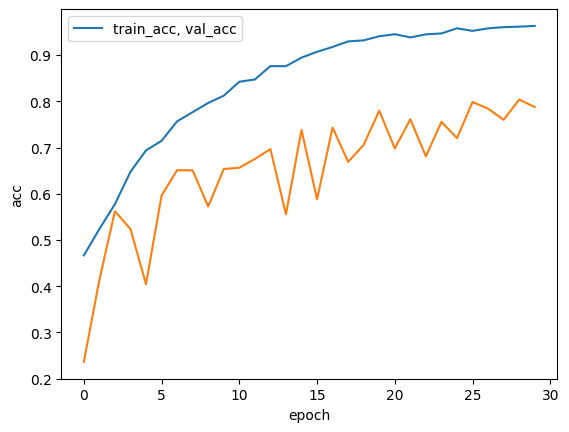

In [66]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.ylabel("acc")
plt.xlabel("epoch")
plt.legend(["train_acc, val_acc"])
plt.show()

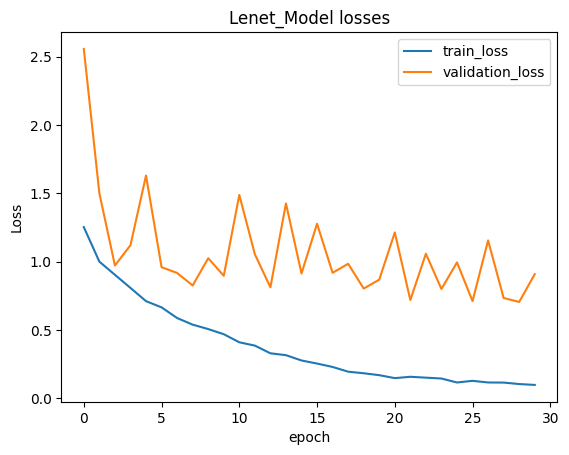

In [67]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Lenet_Model losses")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.legend(["train_loss", "validation_loss"])
plt.show()